In [1]:
import numpy as np
import matplotlib.pyplot as plt
from black_scholes import Black_scholes

# Part I: Option Valuation

## A)

In [11]:
class Monte_carlo():
    def __init__(self, S,r,vol, T, K ,n_samples):
        """
        Black_scholes model class.
        Inputs:
            -   S: stock price
            -   r: risk-free interest rate
            -   vol: volatility fo the stock % in decimals
            -   T: Time period
            -   K: Strike price
            -   n_samples: For big MC simulations
        """

        self.S = S
        self.r = r
        self.vol = vol
        self.T = T
        self.K = K
        self.n_samples = n_samples


    def mc_euler_european(self, seed = None):
        """
        Does MonteCarlo method for H with euler method
        Inputs:
            - n_samples: Number of samples to draw
            - Seed: Seed to use
        """
        np.random.seed(seed)
        n_samples = self.n_samples
        Z = np.random.normal(0,1,size = n_samples)
    
        mc_ST = self.S*np.exp((self.r - 0.5*self.vol**2)*self.T + self.vol*np.sqrt(self.T)*Z)
        mc_Hi = np.maximum(self.K -mc_ST,0)

       
        self.mc_Hi = mc_Hi
        self.mc_std = np.std(mc_Hi) / np.sqrt(n_samples)
        self.mc_rmse = np.sum(((mc_Hi-np.mean(mc_Hi))**2)/n_samples)
        self.mc_H = np.exp(-self.r*self.T)*(np.sum(mc_Hi)/n_samples)
    
        

### Straight convergence

[     1  11112  22223  33334  44445  55556  66667  77778  88889 100000]


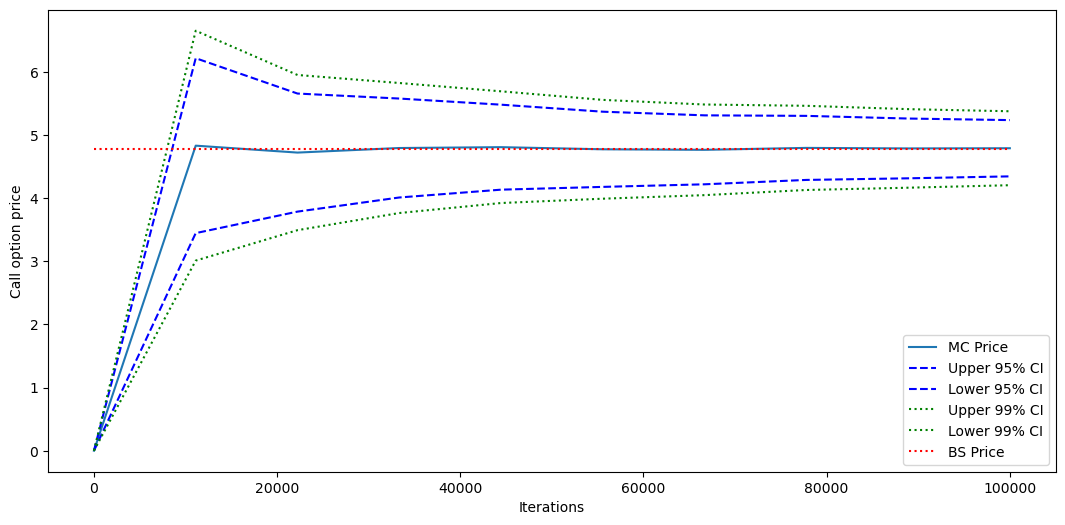

In [17]:
vol = 0.2
N = 100
S = 100
T = 1.
r = 0.06
K = 99
n_samples_list = np.linspace(1,10**5, num = 10, dtype =int)
print(n_samples_list)
mc_prices = []
upper_95 = []
lower_95 = []
upper_99 = []
lower_99 = []
rmse_values = []
z_95 = 1.96
z_99 = 2.576


for n_samples in n_samples_list:
    black_scholes = Monte_carlo(S, r, vol, T, K,n_samples)\
    
    black_scholes.mc_euler_european()
    rmse_values += [black_scholes.mc_rmse]
    mc_prices += [black_scholes.mc_H]

    upper_95 += [black_scholes.mc_H + z_95*black_scholes.mc_rmse/np.sqrt(n_samples)]
    lower_95 += [black_scholes.mc_H - z_95*black_scholes.mc_rmse/np.sqrt(n_samples)]
    
    upper_99 += [black_scholes.mc_H + z_99*black_scholes.mc_rmse/np.sqrt(n_samples)]
    lower_99 += [black_scholes.mc_H - z_99*black_scholes.mc_rmse/np.sqrt(n_samples)]
    
bs = Black_scholes(S,r,vol,T,N,K)
fig,axs = plt.subplots(1,1,figsize = (13,6))

axs.plot(n_samples_list, mc_prices, label=f"MC Price") 
axs.plot(n_samples_list, upper_95, label=f"Upper 95% CI", linestyle= "dashed", color= "blue")
axs.plot(n_samples_list,lower_95, label=f"Lower 95% CI", linestyle= "dashed", color= "blue")
axs.plot(n_samples_list,upper_99, label=f"Upper 99% CI", linestyle= "dotted", color= "green")
axs.plot(n_samples_list,lower_99, label=f"Lower 99% CI", linestyle= "dotted", color= "green")
axs.plot(n_samples_list,np.full(len(n_samples_list), bs.eu_Vt[0]), label=f"BS Price", linestyle= "dotted", color= "red")


axs.set_xlabel("Iterations")
axs.set_ylabel("Call option price")
axs.legend()


In [ ]:
fig,axs = plt.subplots(1,1,figsize = (13,13))
axs.plot(n_samples_list,rmse_values, label=f"Standard error") 
axs.set_xlabel("Iterations")
axs.set_ylabel("Standard error")
axs.legend()
plt.show()

### Volatility and Strike price

In [22]:
## Varying volatility
num = 200
n_samples = 60_000
vol = 0.2
S = 100
T = 1.
r = 0.06
K = 99
vols = np.linspace(0,1,num = num)
Ks = np.linspace(1,99, num = num)
n_samples = 60_000
std = []

bs_vols = np.vectorize(Monte_carlo, excluded=['S','r','T','K','n_samples'])(S,r,vols,T,K,n_samples)
bs_strike = np.vectorize(Monte_carlo, excluded=['S','r''vol','T','n_samples'])(S,r,vol,T,Ks,n_samples)
black_scholes = np.array([bs_vols,bs_strike])
np.vectorize(lambda x: x.mc_euler_european())(black_scholes)
std = np.vectorize(lambda x: x.mc_rmse)(black_scholes)
values = np.vectorize(lambda x: x.mc_H)(black_scholes)


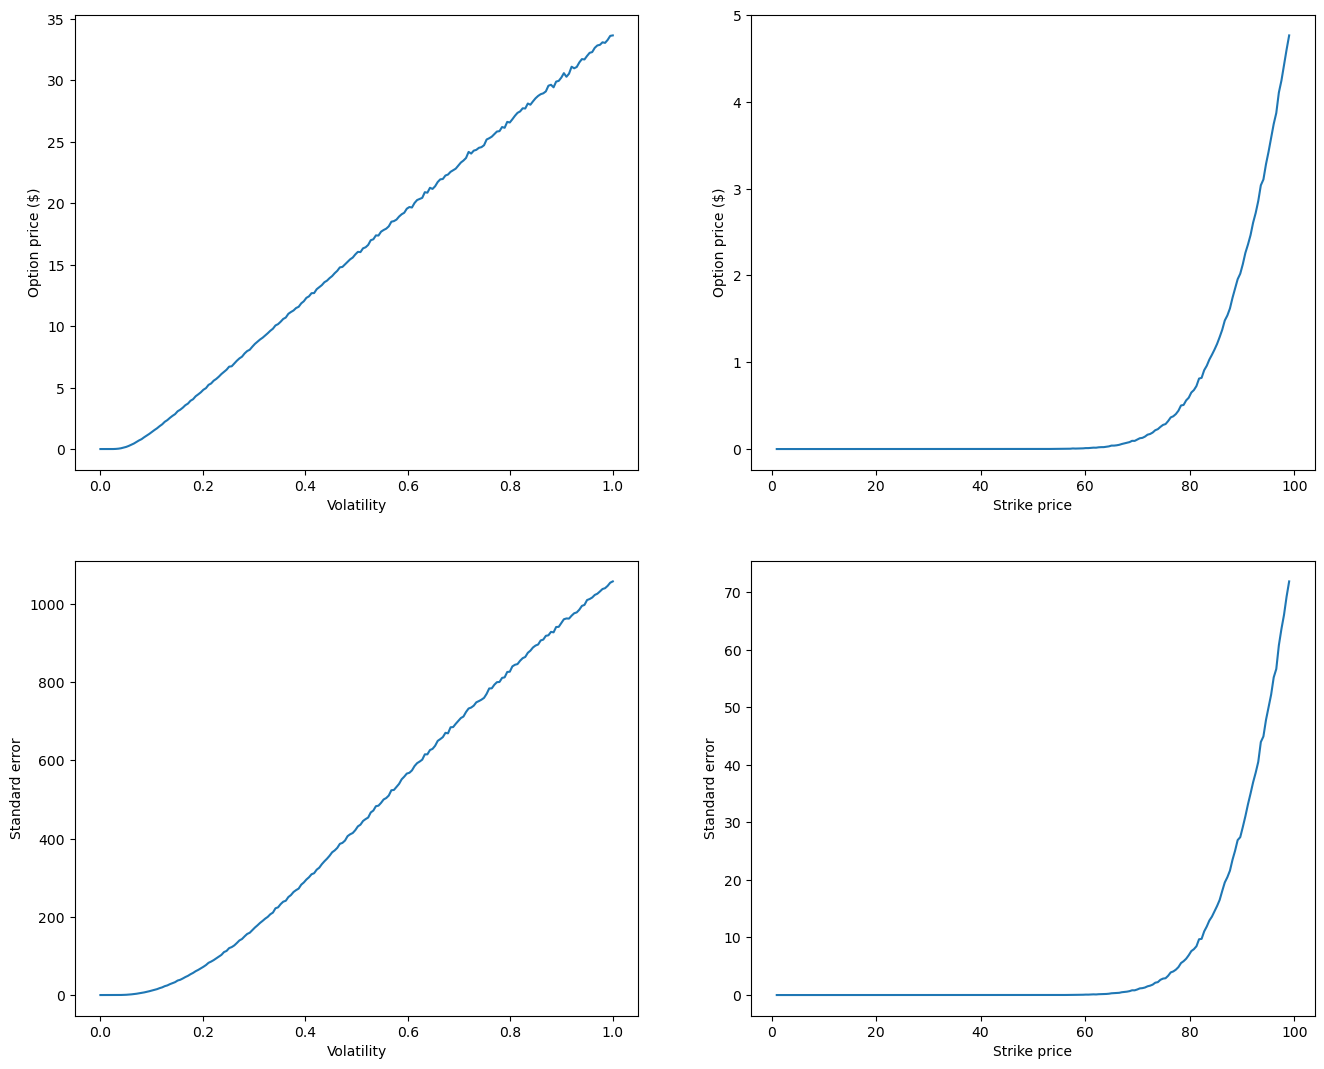

In [26]:
fig,axs = plt.subplots(2,2, figsize = (16,13))
axs = axs.flatten()

axs[0].plot(vols,values[0])

axs[1].plot(Ks,values[1])

axs[0].set_xlabel("Volatility")
axs[0].set_ylabel("Option price ($)")

axs[1].set_xlabel("Strike price")
axs[1].set_ylabel("Option price ($)")


axs[2].plot(vols,std[0])

axs[3].plot(Ks,std[1])

axs[2].set_xlabel("Volatility")
axs[2].set_ylabel("Standard error")

axs[3].set_xlabel("Strike price")
axs[3].set_ylabel("Standard error")

plt.show()

## B)

In [6]:
class Milstein():
    def __init__(self,S,r,T,K,iota,k,sigma,p,B = float('inf'), n_samples = 10_000, n_steps = 252):
        """
        Black_scholes model class.
        Inputs:
            -   S: stock price
            -   r: risk-free interest rate
            -   T: Time period
            -   K: Strike price
            -    Iota: long-term variance
            -    k: Reversion rate
            -    sigma: vol of vol
            -    p: correlation
            -    B: Barrier, default set to infinity
        """
        self.S = S
        self.r = r
        self.T = T  
        self.K = K 

        self.iota = iota
        self.k = k
        self.sigma = sigma
        self.p = p
        self.B = B
        self.n_steps = n_steps
        self.dt = 1/n_steps
        self.n_samples = n_samples

    def milstein_scheme_ar(self,seed = None):
        """
        Does milstein scheme for Heston model using full truncation:
        Inputs:
            -    mode: If using arithmetic or geometric
            -    Seed: Seed to use
        """
        mi_St = np.zeros((self.n_samples,self.n_steps))
        mi_St[:,0] = self.S
        mi_Vt = 0

        ###Pre-computations
        Z_1 = np.random.normal(0,1,size = (self.n_samples,self.n_steps-1))
        Zv = Z_1
        Z_2 = np.random.normal(0,1,size = (self.n_samples,self.n_steps-1))
        Zs = self.p*Z_1 + np.sqrt(1-self.p**2)*Z_2
        ### Stock simulation

        for m in range(1,self.n_steps):
            mi_St[:, m] = mi_St[:, m-1] + self.r*mi_St[:, m-1] *self.dt + np.sqrt(mi_Vt*self.dt)*mi_St[:, m-1] *Zs[:, m-1]  + 1/2 * mi_Vt*mi_St[:, m-1] *self.dt*(Zs[:, m-1] **2 - 1)
            mi_Vt = np.maximum(mi_Vt + self.k*(self.iota - mi_Vt)*self.dt + self.sigma*np.sqrt(mi_Vt*self.dt)*Zv[:, m-1]  + (1/4)*(self.sigma**2)*self.dt*(Zv[:, m-1] -1),0)

        self.mi_Hi = np.exp(-self.r*self.T)*np.maximum(mi_St[:,-1],self.K)
        self.mi_Hi[np.any(mi_St > self.B, axis=1)] = 0
        self.mi_H = np.average(self.mi_Hi)

    def milstein_scheme_geo(self,seed = None):
        """
        Does milstein scheme for Heston model:
        Inputs:
            -    mode: If using arithmetic or geometric
            -    Seed: Seed to use
        """
        mi_St = np.zeros((self.n_samples,self.n_steps))
        mi_St[0] = self.S
        mi_Vt = 0

        ### Begin Pre-computations
        Z_1 = np.random.normal(0,1,size = (self.n_samples,self.n_steps-1))
        Zv = Z_1
        Z_2 = np.random.normal(0,1,size = (self.n_samples,self.n_steps-1))
        Zs = self.p*Z_1 + np.sqrt(1-self.p**2)*Z_2
        ### End pre-computations

        for m in range(1,self.n_steps):
            mi_St[:, m] = mi_St[:, m-1]*np.exp((self.r- 1/2*mi_Vt)*self.dt + np.sqrt(mi_Vt*self.dt)*Zs[:, m-1])
            mi_Vt = np.maximum(mi_Vt + self.k*(self.iota - mi_Vt)*self.dt + self.sigma*np.sqrt(mi_Vt*self.dt)*Zv[:, m-1] + (1/4)*(self.sigma**2)*self.dt*(Zv[:, m-1]-1),0)
            
        self.mi_Hi = np.exp(-self.r*self.T)*np.maximum(mi_St[:,-1],self.K)
        self.mi_Hi[np.any(mi_St > self.B, axis=1)] = 0
        self.mi_H = np.average(self.mi_Hi)

### 10_000 simulation

In [7]:
S = 100
T = 1.
r = 0.05
K = 100
iota = 0.04
k = 2
sigma = 0.1
p = -0.7
B = 125
black_scholes = Milstein(S,r,T,K,iota,k,sigma,p,B)
values = []

black_scholes.milstein_scheme_geo()
print(black_scholes.mi_H)

95.12336956720695


### Barrier B, vol-vol and correlation change

In [8]:

num = 100
S = 100
T = 1.
r = 0.05
K = 100
iota = 0.04
k = 2
sigma = 0.1
p = -0.7
B = 120

## Barrier:change

Bs = np.linspace(120,600, num = num)

black_scholes = np.vectorize(Milstein, excluded=['S','r','T','K','iota','k','sigma','p'])(S,r,T,K,iota,k,sigma,p,Bs)
black_scholes = np.array(black_scholes)
np.vectorize(lambda x: x.milstein_scheme_geo())(black_scholes)
barrier_change = np.vectorize(lambda x: x.mi_H)(black_scholes)
print("First")

## Vol-vol change

sigmas = np.linspace(0,1, num = num)
black_scholes = np.vectorize(Milstein, excluded=['S','r','T','K','iota','k','p','B'])(S,r,T,K,iota,k,sigmas,p,B)
black_scholes = np.array(black_scholes)
np.vectorize(lambda x: x.milstein_scheme_geo())(black_scholes)
vol_change = np.vectorize(lambda x: x.mi_H)(black_scholes) 
print("Second")

## Correlation change
ps = np.linspace(-1,0, num = num)
black_scholes = np.vectorize(Milstein, excluded=['S','r','T','K','iota','k','sigma','B'])(S,r,T,K,iota,k,sigma,ps,B)
black_scholes = np.array(black_scholes)
np.vectorize(lambda x: x.milstein_scheme_geo())(black_scholes)
corr_change = np.vectorize(lambda x: x.mi_H)(black_scholes) 
print("Third")

## Memory cleaning
del black_scholes

First
Second
Third


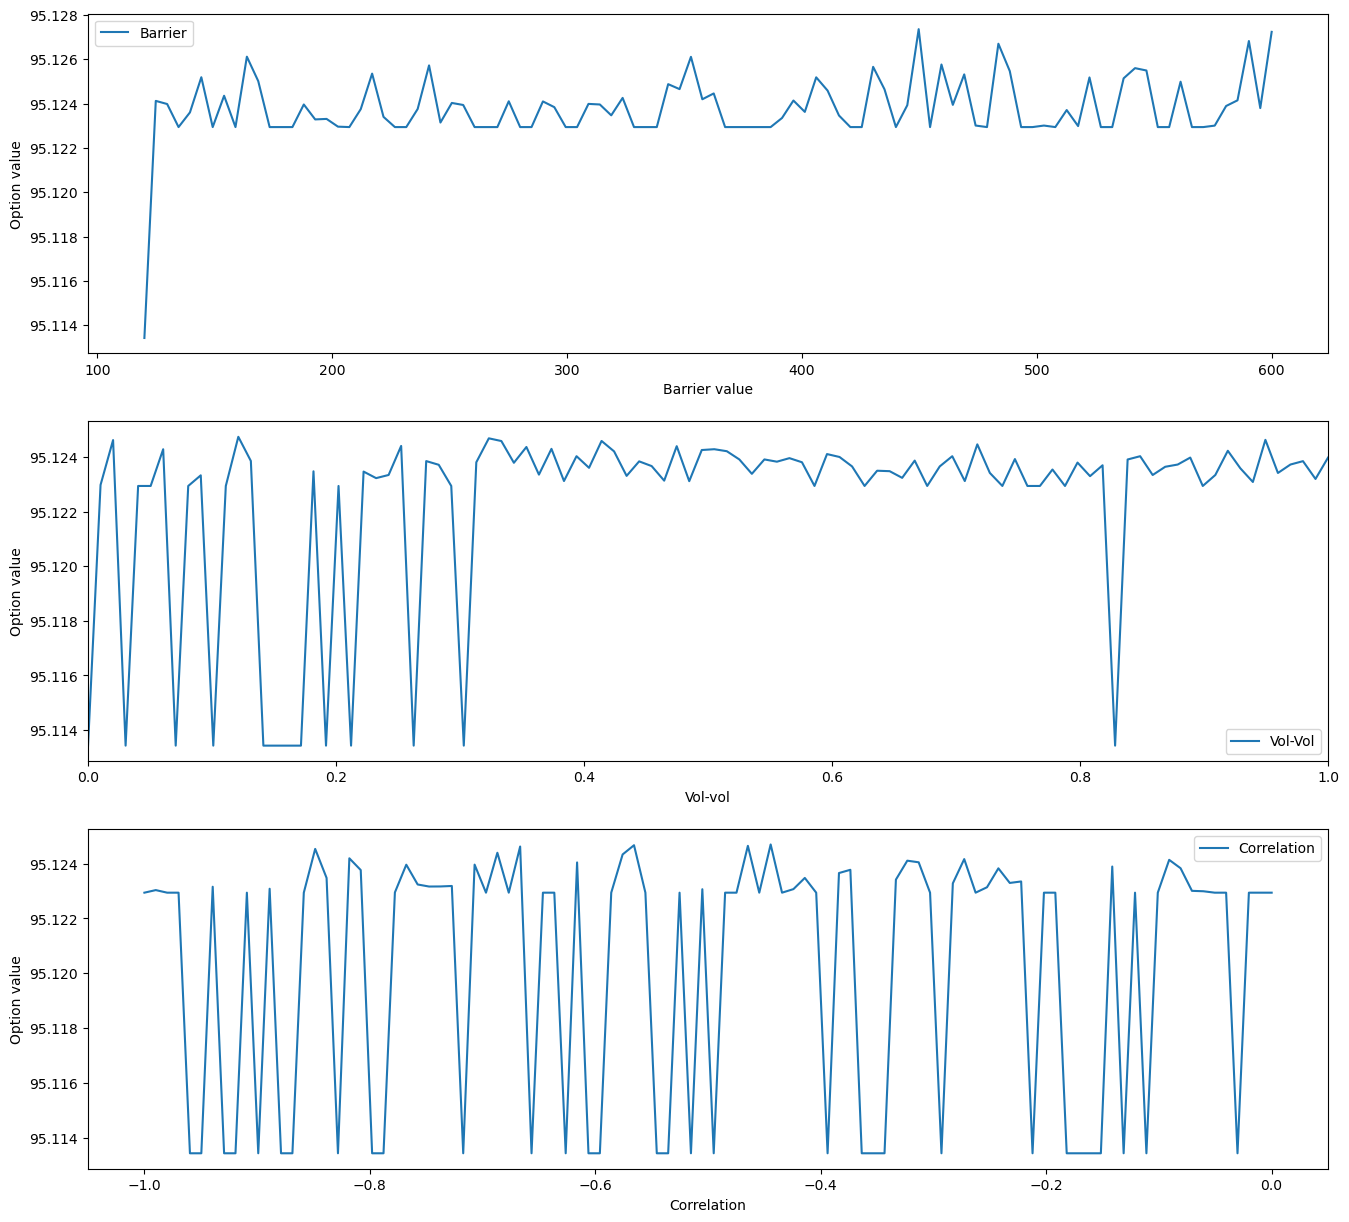

In [10]:
fig,axs = plt.subplots(3,1, figsize = (16,15))
axs[0].plot(Bs,barrier_change, label = "Barrier")
axs[1].plot(sigmas,vol_change, label = "Vol-Vol")
axs[2].plot(ps,corr_change, label = "Correlation")
axs[1].set_xlim(0, 1)
axs[0].legend()
axs[0].set_xlabel("Barrier value")
axs[1].set_xlabel("Vol-vol")
axs[2].set_xlabel("Correlation")

axs[0].set_ylabel("Option value")
axs[1].set_ylabel("Option value")
axs[2].set_ylabel("Option value")

axs[1].legend()
axs[2].legend()

# Part II: Estimation of sensitiviteis if MC

In [24]:
class Deltas():
    def __init__(self, S,r,vol, T, K ,n_samples):
        """
        Black_scholes model class.
        Inputs:
            -   S: stock price
            -   r: risk-free interest rate
            -   vol: volatility fo the stock % in decimals
            -   T: Time period
            -   K: Strike price
            -   n_samples: For big MC simulations
        """

        self.S = S
        self.r = r
        self.vol = vol
        self.T = T
        self.K = K
        self.n_samples = n_samples

    

    def option_value(self, epsilon_smoothing = None, seed = None, digital_option = False):
        """"
        Computes the option value, mainly for monte carlo used
        Inputs:
            - epsilon_smoothing: If use smoothing
            - seed: If use an specific seed
        """

        if seed != None:
            np.random.seed(seed)
        Z = np.random.normal(0,1,size = self.n_samples)
        self.St = self.S*np.exp((self.r - 0.5*self.vol**2)*self.T + self.vol*np.sqrt(self.T)*Z)

        if epsilon_smoothing == None:
            if digital_option == False:
                self.Hi = np.maximum(self.St-self.K,0)
            else:
                self.Hi = np.where((self.St-self.K )>0,1,0)
        elif epsilon_smoothing != None:
            if digital_option == False:
                self.Hi = 1/(1 + np.exp(-(np.maximum(self.St - self.K,0))/epsilon_smoothing))
            else:
                self.Hi = 1/(1 + np.exp(-(np.where((self.St-self.K )>0,1,0))/epsilon_smoothing))


    def bump_revalue(self, bump, epsilon_smoothing = None,seed = None, digital_option = False):
        """
        Does MonteCarlo method for delta parameter
        Inputs:
            - epsilon_smoothing: If use smoothing
            - Seed: Seed to use
        """
        if seed == True:
            seed = np.random.seed()
        
        self.option_value(epsilon_smoothing = epsilon_smoothing, seed = seed, digital_option = digital_option)
        pi = np.exp(-self.r*self.T)*(np.sum(self.Hi)/self.n_samples)

        self.S += bump
        self.option_value(epsilon_smoothing = epsilon_smoothing, seed = seed, digital_option = digital_option)

        pi_bump = np.exp(-self.r*self.T)*(np.sum(self.Hi)/self.n_samples)
        self.delta = (pi_bump-pi)/bump


    def path_wise(self, digital_option = False):
        """
        Does path wise method
        """
 
        Z = np.random.normal(0,1,size = self.n_samples)
        self.St = self.S*np.exp((self.r - 0.5*self.vol**2)*self.T + self.vol*np.sqrt(self.T)*Z)

        self.delta = np.average(np.exp(-self.r*self.T) * (self.St/self.S) * np.where((self.St - self.K) > 0,1,0))
    
    def likelihood_ratio(self, digital_option = False):
        """
        Does likelihood ratio method
        """
        Z = np.random.normal(0,1,size = self.n_samples)
        self.St = self.S*np.exp((self.r - 0.5*self.vol**2)*self.T + self.vol*np.sqrt(self.T)*Z)
        
        Y = (np.log(self.St/self.S) - (self.r -1/2 *self.vol**2)*self.T)/(self.S*(self.vol**2)*self.T)

        if digital_option == False:
            self.delta = np.average(np.exp(-self.r*self.T) * (Y/(self.S*self.vol*self.T)) * np.maximum(self.St - self.K,0))

        elif digital_option == True:
            self.delta = np.average(np.exp(-self.r*self.T) * (Y/(self.S*self.vol*self.T)) * np.where((self.St - self.K) > 0,1,0))
        
        


### 1.Different seeds and Same seeds

In [25]:
S = 100
K = 99
T = 1
r = 0.06
vol = 0.2
n_samples = 10_000

C:\Users\joann\AppData\Local\Temp\ipykernel_10964\2514092324.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  self.delta = (pi_bump-pi)/bump


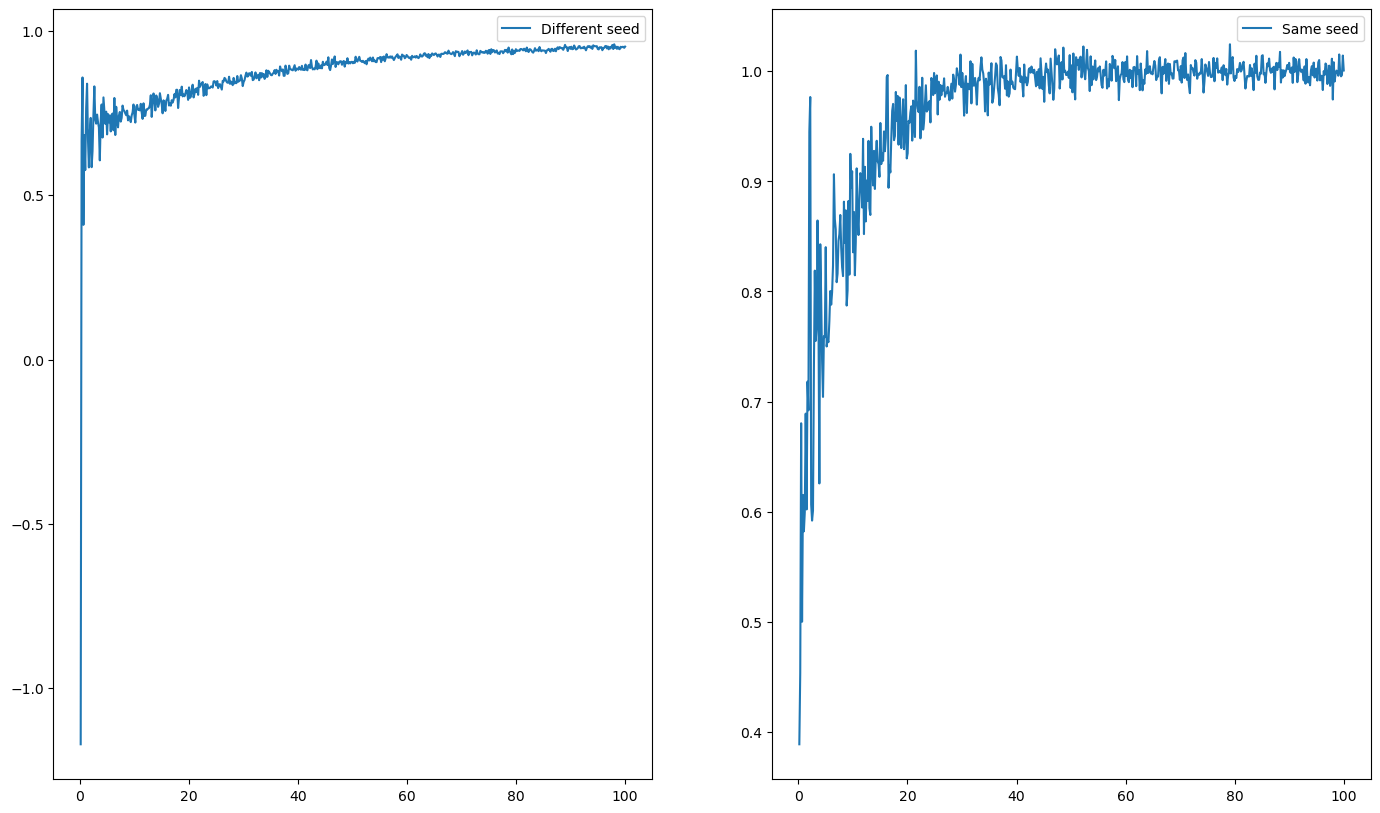

In [26]:
### Without smoothing
bumps = np.linspace(0*S, 1*S, num = 600)
deltas_d = []
deltas_s = []
fig, axs = plt.subplots(1,2, figsize = (17,10))

for bump in bumps:
    black_scholes = Deltas(S,r,vol,T,K,n_samples)
    black_scholes.bump_revalue(bump)
    deltas_d += [black_scholes.delta]
    black_scholes.bump_revalue(bump, seed = True)
    deltas_s += [black_scholes.delta]
    
axs[0].plot(bumps,deltas_d, label = "Different seed")
axs[1].plot(bumps,deltas_s, label = "Same seed")
axs[1].legend()
axs[0].legend()


In [ ]:
## Monte carlo method for financial engineering. Glasserman

C:\Users\joann\AppData\Local\Temp\ipykernel_10964\2514092324.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  self.delta = (pi_bump-pi)/bump


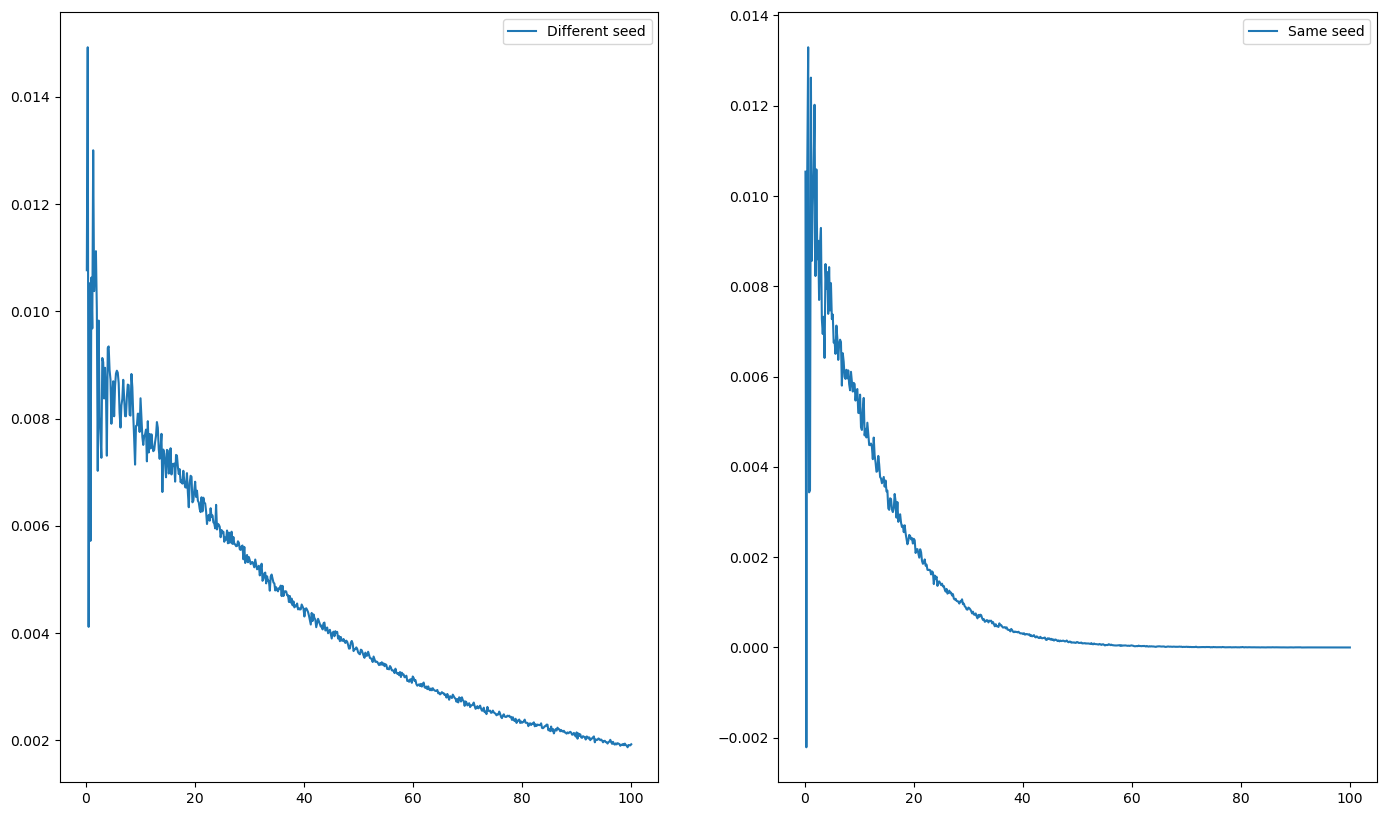

In [27]:
### With smoothing
smoothing = np.linspace(0.001,1, num = 5)
bumps = np.linspace(0*S, 1*S, num = 600)
deltas_d = []
deltas_s = []
fig, axs = plt.subplots(1,2, figsize = (17,10))
for bump in bumps:
    black_scholes = Deltas(S,r,vol,T,K,n_samples)
    black_scholes.bump_revalue(bump,epsilon_smoothing= 0.01)
    deltas_d += [black_scholes.delta]
    black_scholes.bump_revalue(bump,epsilon_smoothing= 0.01, seed = True)
    deltas_s += [black_scholes.delta]
axs[0].plot(bumps,deltas_d, label = "Different seed")
axs[1].plot(bumps,deltas_s, label = "Same seed")
axs[1].legend()
axs[0].legend()

### 2. Digital option

In [19]:
S = 100
K = 99
T = 1
r = 0.06
vol = 0.2
n_samples = 10_000
black_scholes = Deltas(S,r,vol,T,K,n_samples)

#### Bump revalue

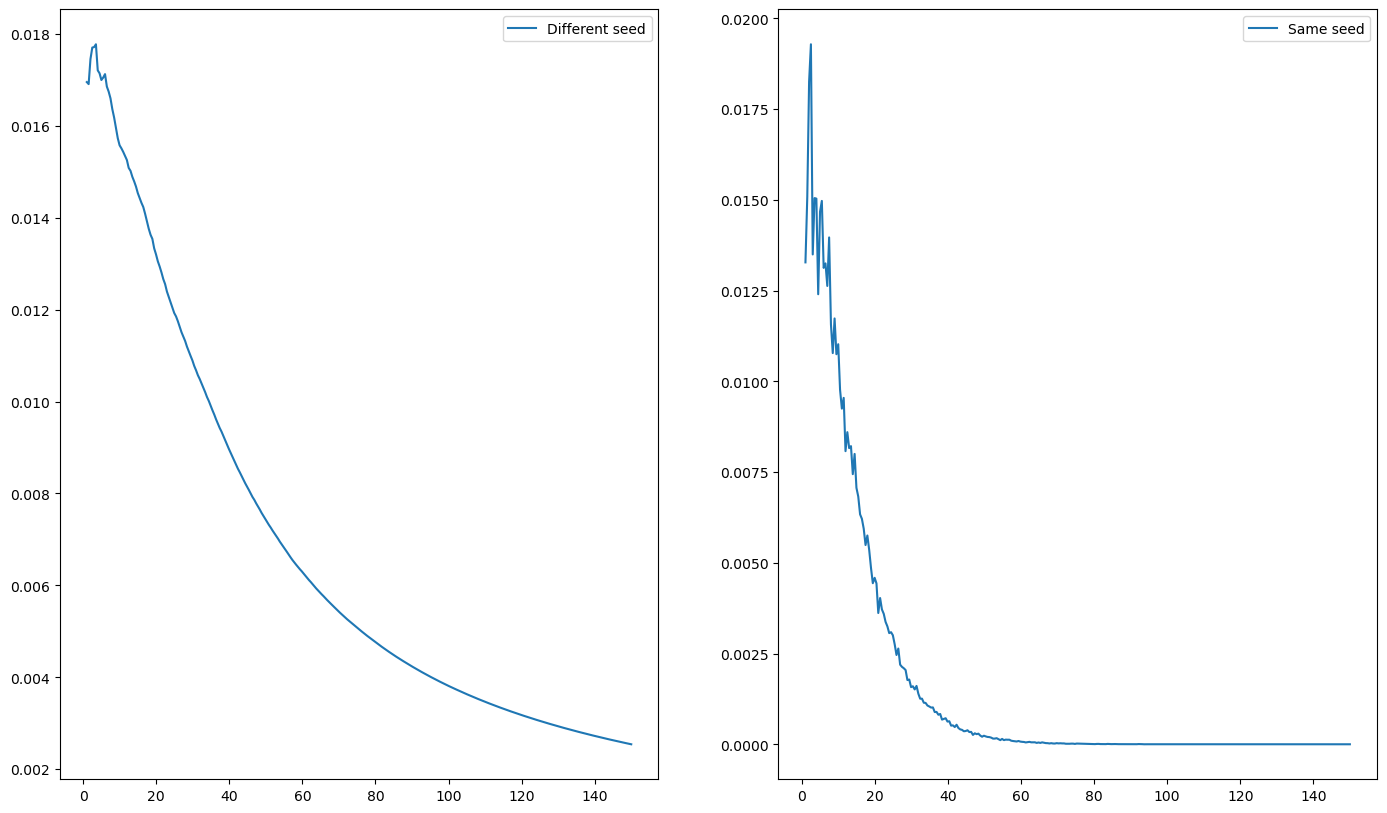

In [20]:
### Bump revalue
### Without smoothing
bumps = np.linspace(1, 150, num = 300)
deltas_d = []
deltas_s = []
fig, axs = plt.subplots(1,2, figsize = (17,10))
for bump in bumps:
    black_scholes = Deltas(S,r,vol,T,K,n_samples)
    black_scholes.bump_revalue(bump, digital_option=True)
    deltas_d += [black_scholes.delta]
    black_scholes.bump_revalue(bump, seed = True, digital_option=True)
    deltas_s += [black_scholes.delta]
axs[0].plot(bumps,deltas_d, label = "Different seed")
axs[1].plot(bumps,deltas_s, label = "Same seed")
axs[1].legend()
axs[0].legend()

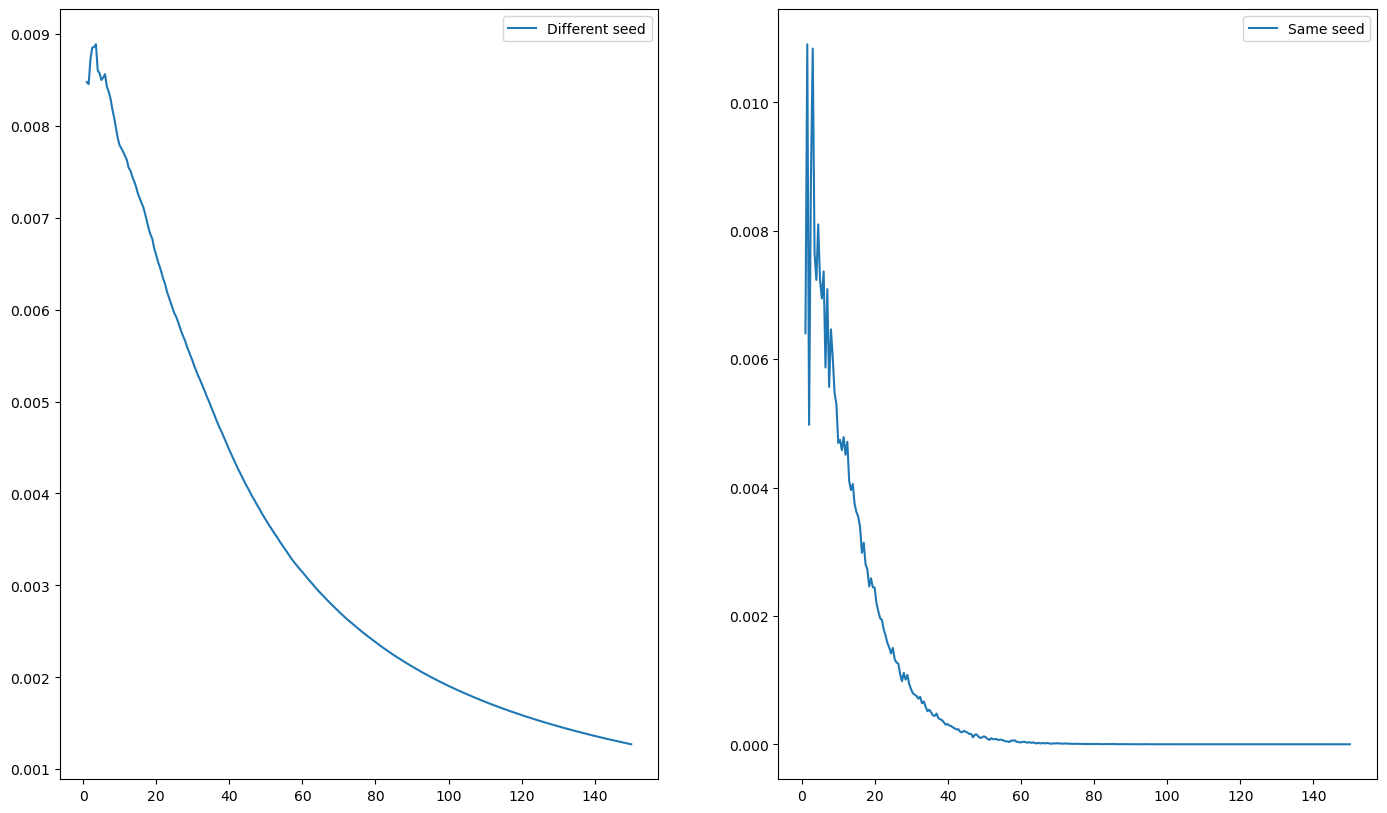

In [43]:
### Bump revalue
### With smoothing
smoothing = 0.001
bumps = np.linspace(1, 150, num = 300)
deltas_d = []
deltas_s = []
fig, axs = plt.subplots(1,2, figsize = (17,10))
for bump in bumps:
    black_scholes = Deltas(S,r,vol,T,K,n_samples)
    black_scholes.bump_revalue(bump,epsilon_smoothing= smoothing, digital_option=True)
    deltas_d += [black_scholes.delta]
    black_scholes.bump_revalue(bump,epsilon_smoothing= 0.01, seed = True, digital_option=True)
    deltas_s += [black_scholes.delta]
axs[0].plot(bumps,deltas_d, label = "Different seed")
axs[1].plot(bumps,deltas_s, label = "Same seed")
axs[1].legend()
axs[0].legend()

#### Pathwise Do not use

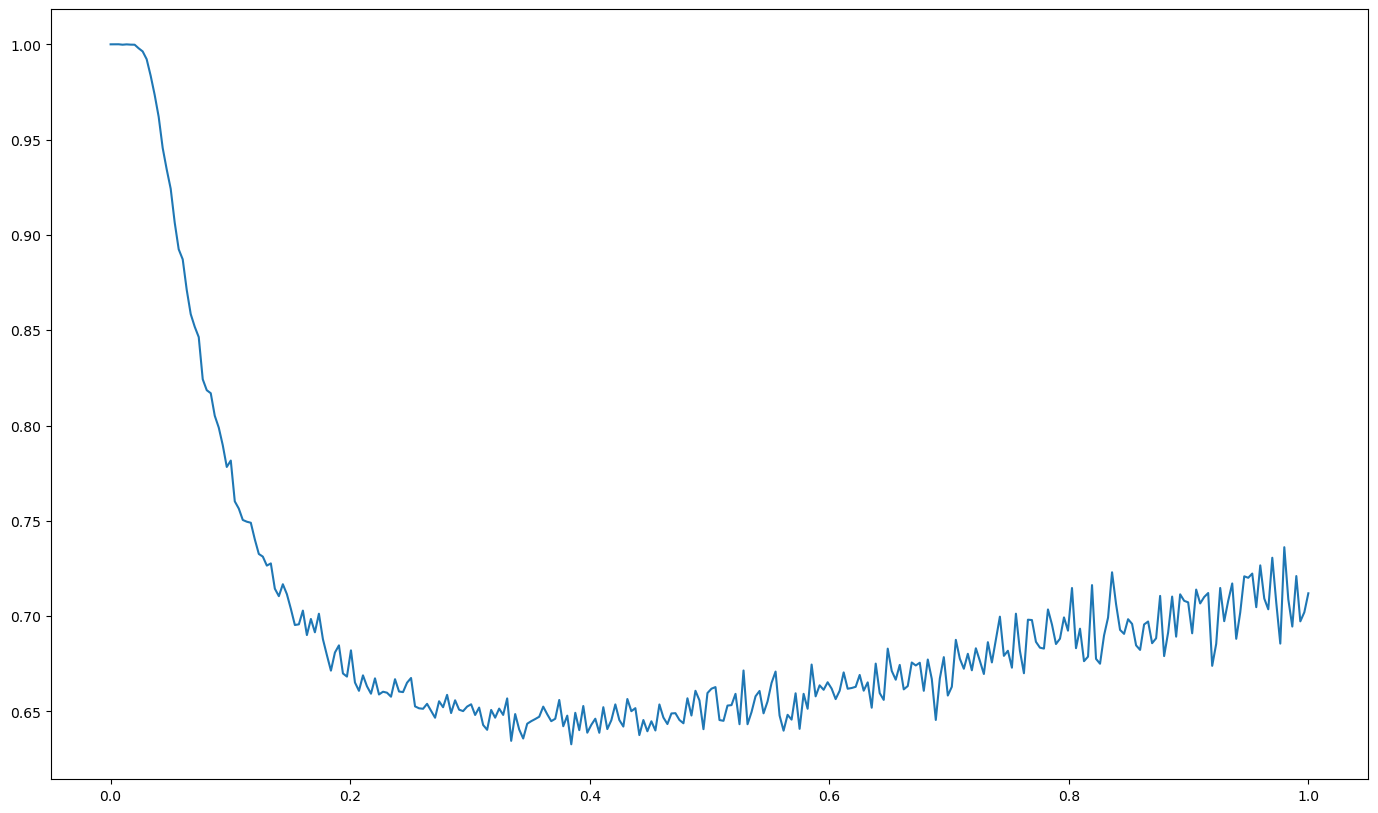

In [21]:
vols = np.linspace(0,1, num = 300)

fig, axs = plt.subplots(1,1, figsize = (17,10))
black_scholes = Deltas(S,r,vol,T,K,n_samples)
black_scholes = np.vectorize(Deltas, excluded=['S','r','T','K','n_samples'])(S,r,vols,T,K,n_samples)
np.vectorize(lambda x: x.path_wise(digital_option=True))(black_scholes)
deltas = np.vectorize(lambda x: x.delta)(black_scholes)

plt.plot(vols, deltas)



#### Likelihood ratio

C:\Users\joann\AppData\Local\Temp\ipykernel_44136\2586368132.py:85: RuntimeWarning: divide by zero encountered in divide
  Y = (np.log(self.St/self.S) - (self.r -1/2 *self.vol**2)*self.T)/(self.S*(self.vol**2)*self.T)


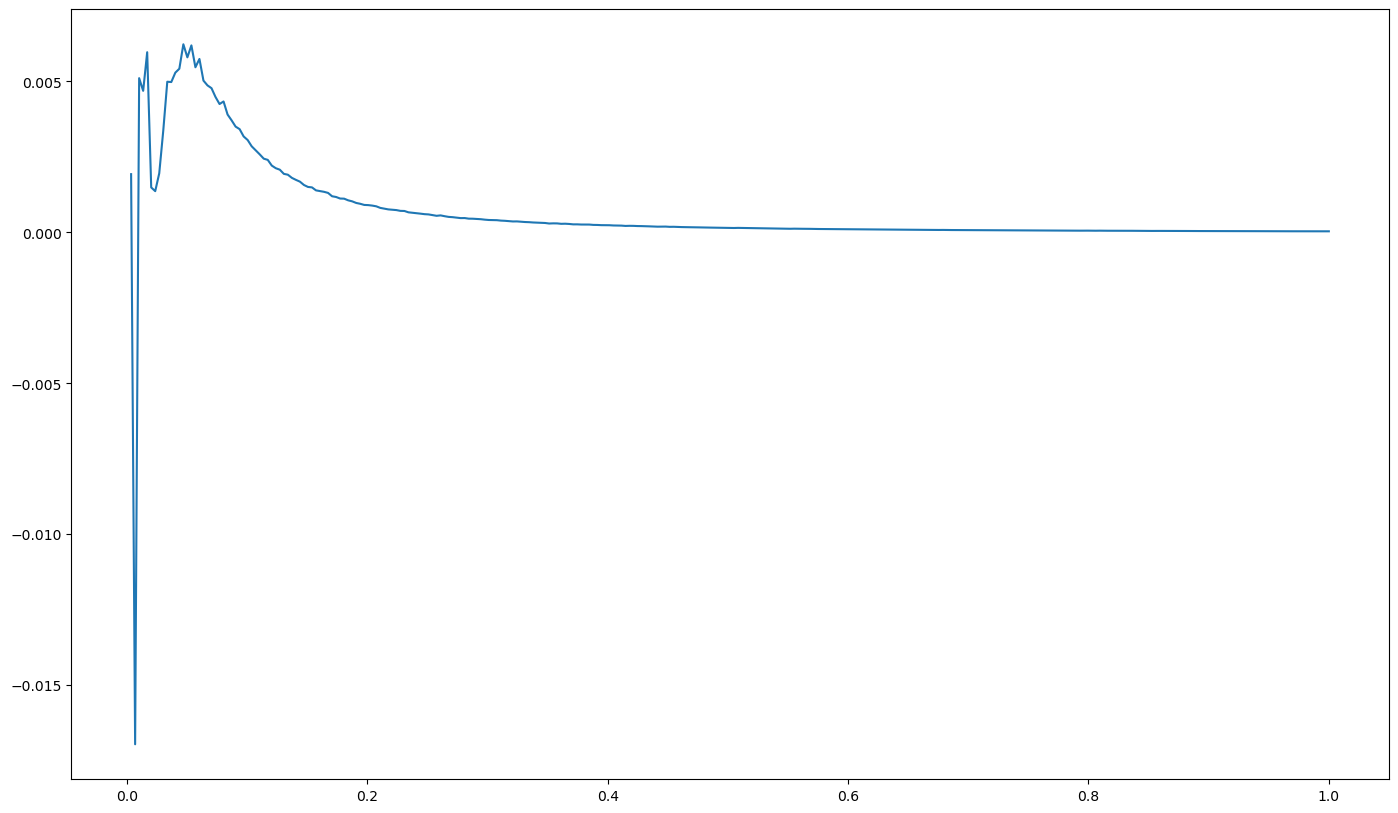

In [22]:
vols = np.linspace(0,1, num = 300)

fig, axs = plt.subplots(1,1, figsize = (17,10))
black_scholes = Deltas(S,r,vol,T,K,n_samples)
black_scholes = np.vectorize(Deltas, excluded=['S','r','T','K','n_samples'])(S,r,vols,T,K,n_samples)
np.vectorize(lambda x: x.likelihood_ratio(digital_option=True))(black_scholes)
deltas = np.vectorize(lambda x: x.delta)(black_scholes)

plt.plot(vols, deltas)


In [ ]:
## Do plot cnovergence by number of samples